In [9]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.linear_model import LinearRegression

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
dataset_location = "C:/Users/thang/OneDrive/Desktop/school/DataChallenge/dataset_for_students/"

In [11]:
scene_df_1 = pd.read_hdf(dataset_location + 'scene.hdf5')

In [12]:
def slice_array(arr, num=10, stride=8):
    t, x, y = arr.shape
    
    slices = []
    
    for i in range(0, x - x // num + 1, stride):
        for j in range(0, y - y // num + 1, stride):
            slice_x_start = i
            slice_x_end = i + x // num
            slice_y_start = j
            slice_y_end = j + y // num
            
            slice_ij = arr[:, slice_x_start:slice_x_end, slice_y_start:slice_y_end]
            slices.append((slice_ij, (slice_x_start, slice_x_end, slice_y_start, slice_y_end)))
    
    return slices

def rebuild_array(slices, original_shape, num=10):
    t, x, y = original_shape
    
    # Initialize an empty array with the original shape
    rebuilt_array = torch.zeros((x, y), device=device)
    weight = torch.zeros((x, y), device=device)
    
    for slice_ij, (slice_x_start, slice_x_end, slice_y_start, slice_y_end) in slices:
        rebuilt_array[slice_x_start:slice_x_end, slice_y_start:slice_y_end] += slice_ij
        weight[slice_x_start:slice_x_end, slice_y_start:slice_y_end] += 1
    
    # Avoid division by zero
    weight[weight == 0] = 1
    return rebuilt_array / weight

def sorted_uniform_pictures(arr):
    """
    Sort (t, x, y) array's t slices from most uniform to least uniform.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array where the t slices are sorted by uniformity.
    """
    t, x, y = arr.shape
    
    # Compute the variance for each t slice
    variances = torch.var(arr, axis=(1, 2))
    
    # Get the sorted indices based on variances
    sorted_indices = torch.argsort(variances)
    
    # Extract and sort the t slices
    sorted_slices = arr[sorted_indices]
    
    return sorted_slices

def pick_regular_slices(arr, num=50):
    """
    Pick a tenth of all t slices in a regular order from a (t, x, y) array.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array with a tenth of the t slices picked in a regular order.
    """
    t, x, y = arr.shape
    
    # Compute the indices to pick a tenth of the t slices at regular intervals
    step = t // num
    indices = torch.arange(0, t, step, device=device)
    
    # Pick slices at the computed indices
    picked_slices = arr[indices]
    
    return picked_slices


In [13]:
def adjust_contrast(image, alpha, beta):
    """
    Adjust the contrast of a grayscale image.

    Parameters:
    image (np.ndarray): Input grayscale image as a NumPy array.
    alpha (float): Contrast control (1.0-3.0).
    beta (int): Brightness control (0-100).

    Returns:
    np.ndarray: Image with adjusted contrast.
    """
    # Apply the contrast adjustment
    adjusted_image = torch.clamp(alpha * image + beta, 0, 255).type(torch.float32)
    
    return adjusted_image

In [14]:
def process_data(df):
    df_image = df['image'].values
    df_image = np.array(df_image.tolist(), dtype=np.float32)
    df_image = torch.tensor(df_image, dtype=torch.float32).to(device)
    return df_image


In [15]:
def pseud_calibration(df, num_slices):
    arr = process_data(df)
    slices = slice_array(arr, num_slices,4)
    t, x, y = arr.shape
    medslice = [sorted_uniform_pictures(s[0]) for s in slices]
    # original_means = [torch.mean(s[0]) for s in slices]

    print(medslice[0].shape)
    tenth = [pick_regular_slices(s) for s in medslice]
    meaned = [torch.mean(t, dim=0) for t in tenth]
    
    reconstructed = rebuild_array(list(zip(meaned, [(s[1][0], s[1][1], s[1][2], s[1][3]) for s in slices])), (t, x, y), num_slices)
    
    # Apply Gaussian blur to the reconstructed image to reduce block edges
    # smoothed_image = cv2.GaussianBlur(reconstructed, (5, 5), 0)
    
    return reconstructed

In [16]:
def applier(df):
    filter = pseud_calibration(df, 32)
    scene = process_data(df)
    filtered_scene = scene - filter
    corrected_scene = adjust_contrast(filtered_scene, alpha=1.1, beta=100)
    corrected_scene = corrected_scene.to(device).numpy()
    return corrected_scene

corrected_img = applier(scene_df_1)

torch.Size([400, 15, 20])


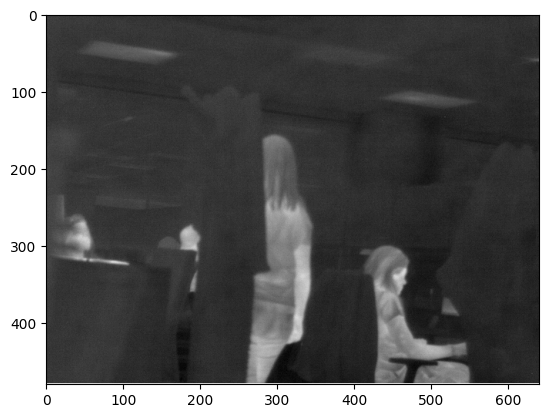

In [17]:
plt.imshow(corrected_img[-1],'gray')
plt.show()